In [13]:
import mne
from mne_bids import BIDSPath
import pandas as pd
from pathlib import Path

processed_data_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data'
bids_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/ds003688'
subject_ids = ['02', '03']

electrode_data = {}

for subject_id in subject_ids:
    sub = str(subject_id)

    bids_path = BIDSPath(subject=sub, session='iemu', datatype='ieeg', root=bids_dir)
    electrodes_path = bids_path.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')

    if electrodes_path.fpath.exists():
        electrodes_df = pd.read_csv(electrodes_path.fpath, sep='\t')
        pos = {}
        for idx, row in electrodes_df.iterrows():
            pos[row['name']] = [row['x'], row['y'], row['z']]
        montage = mne.channels.make_dig_montage(ch_pos=pos, coord_frame='mri')
        electrode_data[subject_id] = montage
        
        print(f"Loaded {len(electrodes_df)} electrodes for subject {subject_id}")
    else:
        print(f"File not found: {electrodes_path.fpath}")

print(f"\nLoaded data for {len(electrode_data)} subjects")
print(f"Subject IDs: {list(electrode_data.keys())}")

Loaded 60 electrodes for subject 02
Loaded 110 electrodes for subject 03

Loaded data for 2 subjects
Subject IDs: ['02', '03']


In [14]:
def get_auditory_picks(electrodes_df):
    auditory_picks = []
    
    for _, row in electrodes_df.iterrows():
        name = row["name"]
        x, y, z = row["x"], row["y"], row["z"]
    
        is_in_auditory_space = (
            abs(x) >= 35 and 
            -20 <= y <= 20 and 
            -10 <= z <= 25
        )
        is_named_auditory = name.startswith((
            "HG", "ST", "sT", "H", "PT", "ST" "A", "AHL", "AHR", 
            "T", "TOL", "ITR", "vT", "MFL", "MFR", "F"
        ))
        
        if is_in_auditory_space or (is_named_auditory and abs(x) >= 30):
            auditory_picks.append(name)
    
    return auditory_picks

auditory_electrodes = {}

for subject_id in subject_ids:
    sub = str(subject_id)
    
    bids_path = BIDSPath(subject=sub, session='iemu', datatype='ieeg', root=bids_dir)
    electrodes_path = bids_path.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')
    
    if electrodes_path.fpath.exists():
        electrodes_df_sub = pd.read_csv(electrodes_path.fpath, sep='\t')
        auditory_channels = get_auditory_picks(electrodes_df_sub)
        
        auditory_electrodes[subject_id] = auditory_channels
        
        print(f"Subject {subject_id}: {len(auditory_channels)} auditory electrodes selected")
        print(f"  Channels: {auditory_channels}")
    else:
        print(f"Subject {subject_id}: Electrode file not found")
        auditory_electrodes[subject_id] = []

print(f"\nTotal subjects with auditory electrode data: {len(auditory_electrodes)}")

Subject 02: 37 auditory electrodes selected
  Channels: ['F04', 'F05', 'F06', 'F07', 'F08', 'F12', 'F13', 'F14', 'F15', 'F16', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48']
Subject 03: 65 auditory electrodes selected
  Channels: ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F41', 'F42', 'F43', 'F44', 'F45', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'FP6', 'FP7', 'FP8', 'HF1', 'HF2', 'HF3', 'HF4']

Total subjects with auditory electrode data: 2


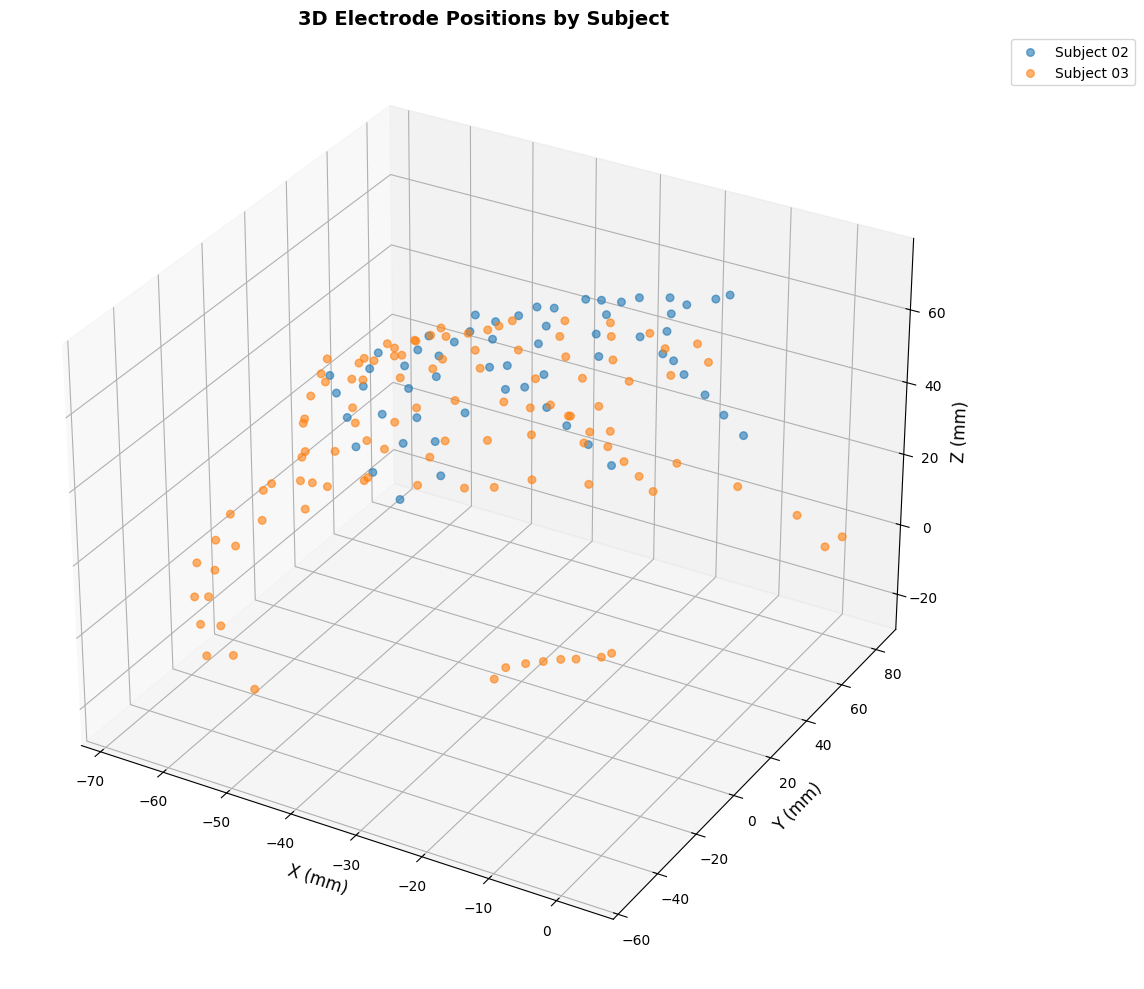

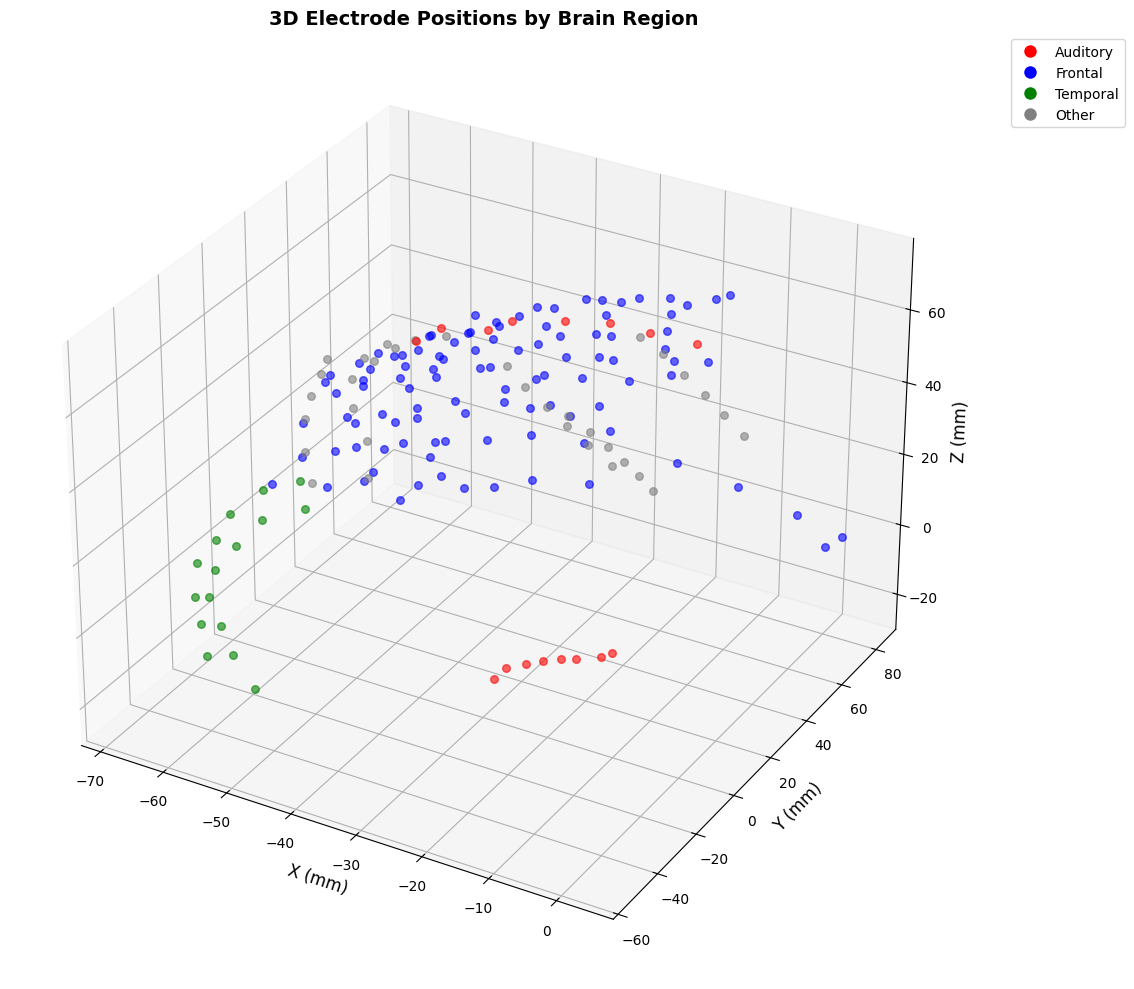

In [15]:
import matplotlib.pyplot as plt

# Generate colors for each subject
colors = plt.cm.tab10(range(len(subject_ids)))

# Plot 1: 3D scatter plot colored by subject
fig1 = plt.figure(figsize=(14, 10))
ax1 = fig1.add_subplot(111, projection='3d')

for idx, subject_id in enumerate(subject_ids):
    sub = str(subject_id)
    
    bids_path_temp = BIDSPath(subject=sub, session='iemu', datatype='ieeg', root=bids_dir)
    electrodes_path_temp = bids_path_temp.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')
    
    if electrodes_path_temp.fpath.exists():
        electrodes_df_temp = pd.read_csv(electrodes_path_temp.fpath, sep='\t')
        
        x_coords = electrodes_df_temp['x'].values
        y_coords = electrodes_df_temp['y'].values
        z_coords = electrodes_df_temp['z'].values
        
        ax1.scatter(x_coords, y_coords, z_coords, 
                   c=[colors[idx]], 
                   label=f'Subject {subject_id}',
                   alpha=0.6,
                   s=30)

ax1.set_xlabel('X (mm)', fontsize=12)
ax1.set_ylabel('Y (mm)', fontsize=12)
ax1.set_zlabel('Z (mm)', fontsize=12)
ax1.set_title('3D Electrode Positions by Subject', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

plt.tight_layout()
plt.show()

# Plot 2: 3D scatter plot colored by brain region
def get_brain_region(electrode_name):
    """Determine brain region from electrode name"""
    if electrode_name.startswith(('HG', 'ST', 'sT', 'H', 'PT', 'A', 'AHL', 'AHR', 'TOL')):
        return 'Auditory'
    elif electrode_name.startswith(('F', 'FB', 'Fb', 'Fp', 'FH', 'MFL', 'MFR')):
        return 'Frontal'
    elif electrode_name.startswith(('T', 'ITR', 'vT')):
        return 'Temporal'
    elif electrode_name.startswith('P'):
        return 'Parietal'
    elif electrode_name.startswith('IH'):
        return 'Insular/Hippocampus'
    else:
        return 'Other'

fig2 = plt.figure(figsize=(14, 10))
ax2 = fig2.add_subplot(111, projection='3d')

region_colors = {'Auditory': 'red', 'Frontal': 'blue', 'Temporal': 'green', 
                 'Parietal': 'orange', 'Insular/Hippocampus': 'purple', 'Other': 'gray'}

all_regions = []
for subject_id in subject_ids:
    sub = str(subject_id)
    
    bids_path_temp = BIDSPath(subject=sub, session='iemu', datatype='ieeg', root=bids_dir)
    electrodes_path_temp = bids_path_temp.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')
    
    if electrodes_path_temp.fpath.exists():
        electrodes_df_temp = pd.read_csv(electrodes_path_temp.fpath, sep='\t')
        
        for _, row in electrodes_df_temp.iterrows():
            region = get_brain_region(row['name'])
            all_regions.append(region)
            
            ax2.scatter(row['x'], row['y'], row['z'], 
                       c=region_colors[region], 
                       alpha=0.6,
                       s=30)

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=color, markersize=10, label=region)
                   for region, color in region_colors.items() 
                   if region in all_regions]

ax2.set_xlabel('X (mm)', fontsize=12)
ax2.set_ylabel('Y (mm)', fontsize=12)
ax2.set_zlabel('Z (mm)', fontsize=12)
ax2.set_title('3D Electrode Positions by Brain Region', fontsize=14, fontweight='bold')
ax2.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

plt.tight_layout()
plt.show()

In [16]:
import os
import glob
import numpy as np

# Load EEG data and create epochs based on events

epochs_dict = {}

for subject_id in subject_ids:
    sub = str(subject_id)
    
    # Load the preprocessed .fif file
    file_path = f'{processed_data_dir}/sub{sub}_preprocessed-raw.fif'
    raw = mne.io.read_raw_fif(file_path, preload=True)
    print(f"\nSubject {subject_id}: Loaded raw data with {len(raw.ch_names)} channels")
    
    # Load events from BIDS
    events_pattern = os.path.join(bids_dir, f'sub-{sub}', 'ses-iemu', 'ieeg', 
                                    f'sub-{sub}_ses-iemu_task-film_run-*_events.tsv')
    events_files = glob.glob(events_pattern)
        
    if events_files:
        events_file = events_files[0]
        events_df = pd.read_csv(events_file, sep='\t')
        run_num = os.path.basename(events_file).split('run-')[1].split('_')[0]
        print(f"  Found events file with run={run_num}")
        print(f"Subject {subject_id}: Loaded {len(events_df)} events")
    else:
        raise FileNotFoundError(f"No events file found for subject {sub}")
    
    # Convert events to MNE format
    events = np.column_stack([
        (events_df['onset'] * raw.info['sfreq']).astype(int),
        np.zeros(len(events_df), dtype=int),
        events_df['trial_type'].astype('category').cat.codes
    ])
    
    # Create event_id mapping
    event_id = {trial_type: code for code, trial_type in 
                enumerate(events_df['trial_type'].unique())}
    
    print(f"Subject {subject_id}: Event types: {event_id}")
    
    # Create epochs (-0.5 to 2.0 seconds around event onset)
    epochs = mne.Epochs(raw, events, event_id, tmin=-0.5, tmax=2.0, 
                       baseline=(-0.5, 0), preload=True, event_repeated='merge')
    
    # Count music and speech epochs
    n_music = len(epochs['music']) if 'music' in event_id else 0
    n_speech = len(epochs['speech']) if 'speech' in event_id else 0
    
    # Store epochs
    epochs_dict[subject_id] = {
        'epochs': epochs,
        'event_id': event_id
    }
    
    print(f"Subject {subject_id}: Created {len(epochs)} epochs")
    print(f"  Event counts: {dict(zip(*np.unique(epochs.events[:, -1], return_counts=True)))}")
    print(f"  Music epochs: {n_music}, Speech epochs: {n_speech}")

print(f"\nTotal subjects with epoched data: {len(epochs_dict)}")


Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub02_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 291997 =      0.000 ...   570.307 secs
Ready.
Reading 0 ... 291997  =      0.000 ...   570.307 secs...

Subject 02: Loaded raw data with 59 channels
  Found events file with run=1
Subject 02: Loaded 15 events
Subject 02: Event types: {'start task': 0, 'music': 1, 'speech': 2, 'end task': 3}
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 14 events and 1281 original time points ...
0 bad epochs dropped
Subject 02: Created 14 epochs
  Event counts: {np.int64(0): np.int64(1), np.int64(1): np.int64(6), np.int64(2): np.int64(6), np.int64(4): np.int64(1)}
  Music epochs: 7, Speech epochs: 6
Opening raw data file /home/inesh_roy/iEEG-Analysis

Isotrak not found
    Range : 0 ... 200476 =      0.000 ...   391.555 secs
Ready.
Reading 0 ... 200476  =      0.000 ...   391.555 secs...

Subject 03: Loaded raw data with 101 channels
  Found events file with run=1
Subject 03: Loaded 15 events
Subject 03: Event types: {'start task': 0, 'music': 1, 'speech': 2, 'end task': 3}
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 1281 original time points ...
1 bad epochs dropped
Subject 03: Created 14 epochs
  Event counts: {np.int64(1): np.int64(7), np.int64(2): np.int64(6), np.int64(3): np.int64(1)}
  Music epochs: 7, Speech epochs: 6

Total subjects with epoched data: 2


In [17]:
import numpy as np
import mne

# 1. Frequency and Cycle Optimization
# If 1Hz is causing the overflow, we can start at 2 or 3Hz 
# which are often more reliable for short epochs anyway.
freqs = np.logspace(np.log10(2), np.log10(150), num=50) 

# Adjust cycles to be shorter at the low end to fit the 1281 sample limit
# Formula: Wavelet length in samples = (n_cycles / freq) * sampling_rate
# For your 512Hz or 1024Hz data, 3 cycles at 2Hz is usually safe.
n_cycles = np.logspace(np.log10(3), np.log10(12), num=50) 

tfr_dict = {}

for subject_id in subject_ids:
    epochs_obj = epochs_dict[subject_id]['epochs']
    
    # 2. Compute TFR with safety check
    # n_jobs=1 is safer inside loops to avoid nested parallelization errors
    power = mne.time_frequency.tfr_morlet(
        epochs_obj, 
        freqs=freqs, 
        n_cycles=n_cycles, 
        return_itc=False,
        average=False, 
        n_jobs=1,      
        verbose=False
    )
    
    tfr_dict[subject_id] = power
    print(f"Subject {subject_id}: TFR shape = {power.data.shape}")

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Subject 02: TFR shape = (14, 59, 50, 1281)
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Subject 03: TFR shape = (14, 101, 50, 1281)


Subject 02: Rest condition found
Subject 03: Rest condition found


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
No baseline correction applied
No baseline correction applied


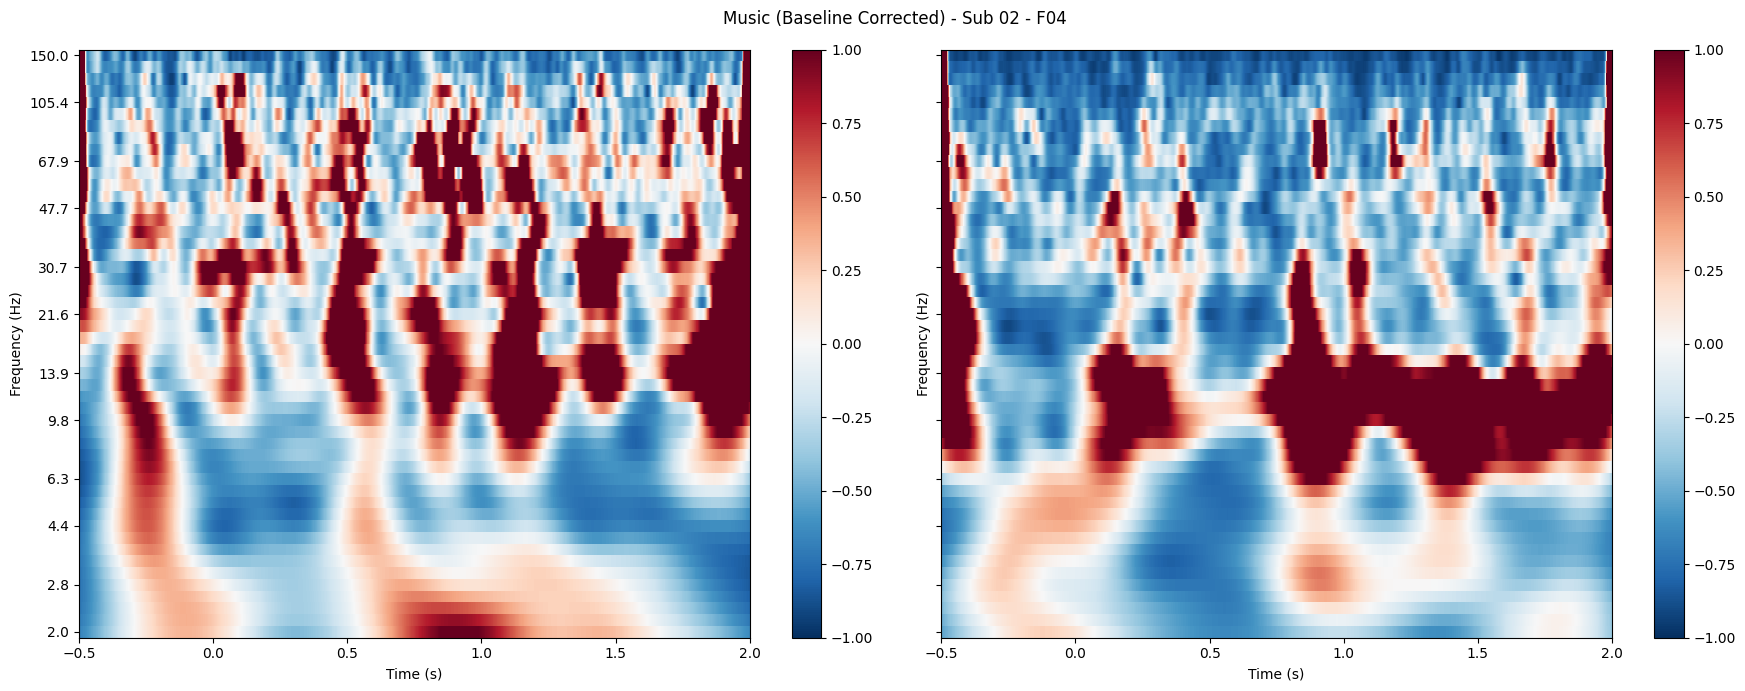


Baseline-corrected spectrograms plotted for subject 02, channel F04


In [18]:
# Baseline correction using the 'rest' condition and replot spectrograms

# First, let's check if 'rest' exists in the event types
for subject_id in subject_ids:
    event_id = epochs_dict[subject_id]['event_id']
    if 'start task' in event_id:
        print(f"Subject {subject_id}: Rest condition found")
    else:
        print(f"Subject {subject_id}: Available conditions: {list(event_id.keys())}")

# Apply baseline using 'start task' or 'end task' as rest periods if 'rest' doesn't exist
# We'll use the pre-stimulus baseline period from the epochs

# Recompute spectrograms with baseline correction for the example subject
example_subject = '02'
auditory_ch = auditory_electrodes[example_subject][0] if auditory_electrodes[example_subject] else tfr_dict[example_subject].ch_names[0]

# Get TFR data for speech and music conditions - select epochs first, then average
tfr_speech = tfr_dict[example_subject]['speech'].copy().average()
tfr_music = tfr_dict[example_subject]['music'].copy().average()

# Apply baseline correction (using the pre-stimulus period: -0.5 to 0 s)
tfr_speech.apply_baseline(baseline=(-0.5, 0), mode='percent')
tfr_music.apply_baseline(baseline=(-0.5, 0), mode='percent')

# Plot with baseline correction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

plot_params = dict(
    picks=[auditory_ch],
    baseline=None,  # Already applied above
    cmap='RdBu_r',
    show=False,
    colorbar=True,
    vlim=(-1, 1)  # Use vlim instead of vmin/vmax
)

tfr_speech.plot(title=f'Speech (Baseline Corrected) - Sub {example_subject} - {auditory_ch}', 
                axes=ax1, **plot_params)
tfr_music.plot(title=f'Music (Baseline Corrected) - Sub {example_subject} - {auditory_ch}', 
               axes=ax2, **plot_params)

plt.tight_layout()
plt.show()

print(f"\nBaseline-corrected spectrograms plotted for subject {example_subject}, channel {auditory_ch}")


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Available auditory channels in TFR: 36 out of 37
No baseline correction applied
No baseline correction applied


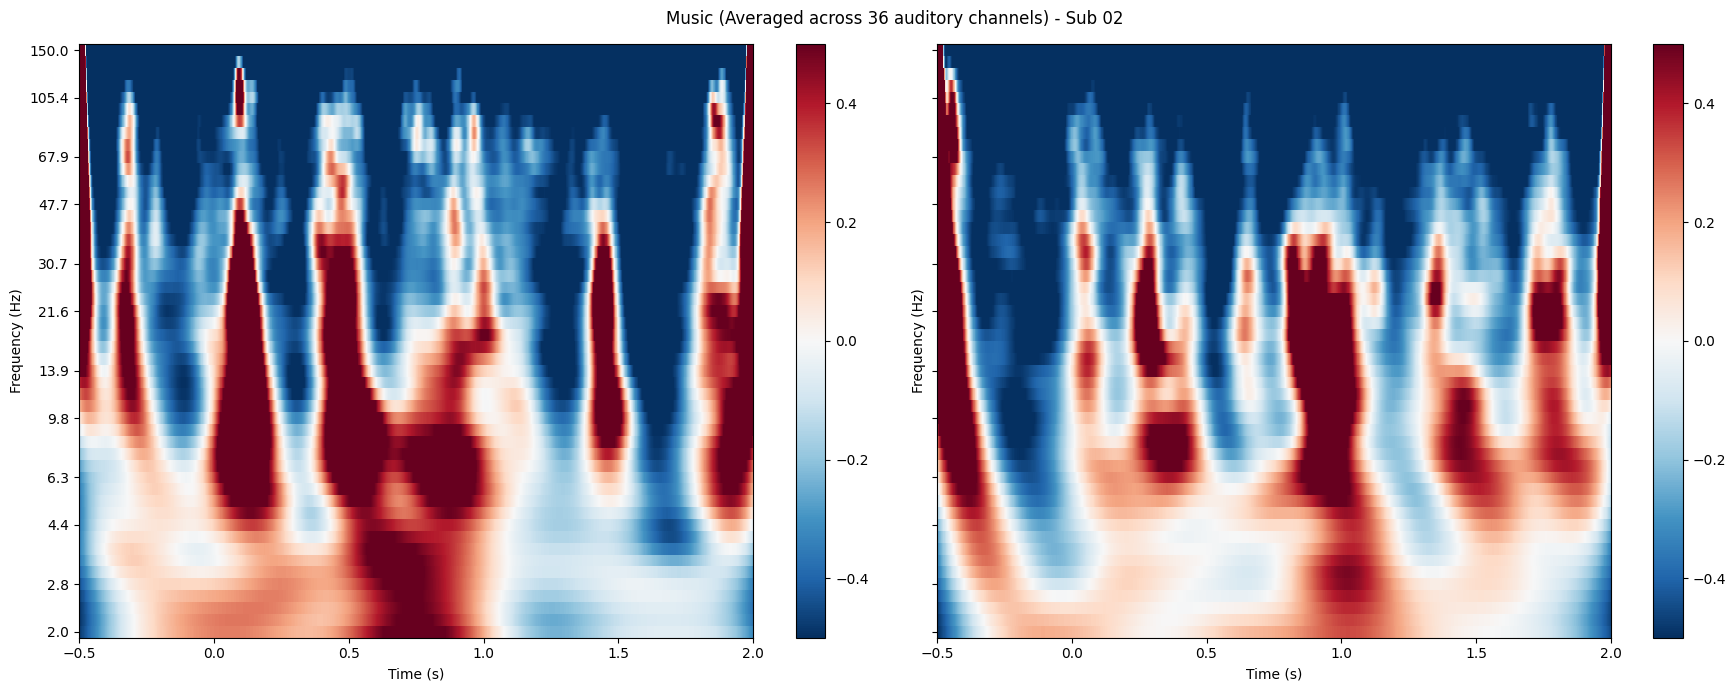


Plotted spectrograms for subject 02 averaged across 36 auditory channels


In [23]:
# Average TFR across all auditory channels for subject 02 only

# Get auditory channels for subject 02
auditory_chs_sub02 = auditory_electrodes['02']

# Get TFR for subject 02
tfr_speech_sub02 = tfr_dict['02']['speech'].copy().average()
tfr_music_sub02 = tfr_dict['02']['music'].copy().average()

# Apply baseline correction
tfr_speech_sub02.apply_baseline(baseline=(-0.5, 0), mode='percent')
tfr_music_sub02.apply_baseline(baseline=(-0.5, 0), mode='percent')

# Filter to only auditory channels that exist in the TFR data
available_auditory_chs = [ch for ch in auditory_chs_sub02 if ch in tfr_speech_sub02.ch_names]
print(f"Available auditory channels in TFR: {len(available_auditory_chs)} out of {len(auditory_chs_sub02)}")

# Average across auditory channels only
tfr_speech_auditory = tfr_speech_sub02.copy().pick(available_auditory_chs)
tfr_music_auditory = tfr_music_sub02.copy().pick(available_auditory_chs)

# Get the averaged data
avg_speech_auditory = tfr_speech_auditory.data.mean(axis=0)
avg_music_auditory = tfr_music_auditory.data.mean(axis=0)

# Create TFR objects for plotting
tfr_speech_avg = tfr_speech_auditory.copy()
tfr_speech_avg.data = avg_speech_auditory[np.newaxis, :, :]
tfr_speech_avg = tfr_speech_avg.pick([0])
tfr_speech_avg.info['chs'][0]['ch_name'] = 'Auditory_Avg'
tfr_speech_avg.info._update_redundant()

tfr_music_avg = tfr_music_auditory.copy()
tfr_music_avg.data = avg_music_auditory[np.newaxis, :, :]
tfr_music_avg = tfr_music_avg.pick([0])
tfr_music_avg.info['chs'][0]['ch_name'] = 'Auditory_Avg'
tfr_music_avg.info._update_redundant()

# Plot the averaged TFR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

plot_params = dict(
    baseline=None,
    cmap='RdBu_r',
    show=False,
    colorbar=True,
    vlim=(-0.5, 0.5)
)

tfr_speech_avg.plot(title=f'Speech (Averaged across {len(available_auditory_chs)} auditory channels) - Sub 02', 
                    axes=ax1, **plot_params)
tfr_music_avg.plot(title=f'Music (Averaged across {len(available_auditory_chs)} auditory channels) - Sub 02', 
                   axes=ax2, **plot_params)

plt.tight_layout()
plt.show()

print(f"\nPlotted spectrograms for subject 02 averaged across {len(available_auditory_chs)} auditory channels")
